# 1. Setup

In [1]:
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from PIL import Image
from sklearn.metrics import accuracy_score

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchvision.models import resnet18

tqdm.pandas()

/opt/conda/lib/python3.7/site-packages/tqdm/std.py:668: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


In [2]:
language = 'Punjabi'
data_dir = f'Data/{language}'
train_dir = f'{data_dir}/Train'
val_dir = f'{data_dir}/Val'
test_dir = f'{data_dir}/Test'

In [3]:
character_df_fp = f'Data/Characters/Characters-{language}.csv'

In [4]:
cpu_count = 16
print(cpu_count)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

16
cuda


# 2. Define character class

In [5]:
character_df = pd.read_csv(character_df_fp)
print(character_df.shape)
character_df.head()

(696, 3)


,Character,Consonant,Glyph
0,ਅ,-,-
1,ਆ,-,ਾ
2,ਇ,-,ਿ
3,ਈ,-,ੀ
4,ਉ,-,ੁ


In [6]:
#character_df[character_df['Consonant']=="-"]

In [7]:
characters = set()
for character in character_df['Character'].values:
    characters.update(list(character))
characters = ["-"] + sorted(list(characters))
print(len(characters))
print(characters)

67
['-', 'ਁ', 'ਃ', 'ਅ', 'ਆ', 'ਇ', 'ਈ', 'ਉ', 'ਊ', 'ਏ', 'ਐ', 'ਓ', 'ਔ', 'ਕ', 'ਖ', 'ਗ', 'ਘ', 'ਙ', 'ਚ', 'ਛ', 'ਜ', 'ਝ', 'ਞ', 'ਟ', 'ਠ', 'ਡ', 'ਢ', 'ਣ', 'ਤ', 'ਥ', 'ਦ', 'ਧ', 'ਨ', 'ਪ', 'ਫ', 'ਬ', 'ਭ', 'ਮ', 'ਯ', 'ਰ', 'ਲ', 'ਲ਼', 'ਵ', 'ਸ਼', 'ਸ', 'ਹ', '਼', 'ਾ', 'ਿ', 'ੀ', 'ੁ', 'ੂ', 'ੇ', 'ੈ', 'ੋ', 'ੌ', '੍', 'ੑ', 'ਖ਼', 'ਗ਼', 'ਜ਼', 'ੜ', 'ਫ਼', 'ੰ', 'ੱ', 'ੲ', 'ੳ']


In [8]:
idx2char = {k:v for k,v in enumerate(characters)}
print(idx2char)
char2idx = {v:k for k,v in idx2char.items()}
print(char2idx)

{0: '-', 1: 'ਁ', 2: 'ਃ', 3: 'ਅ', 4: 'ਆ', 5: 'ਇ', 6: 'ਈ', 7: 'ਉ', 8: 'ਊ', 9: 'ਏ', 10: 'ਐ', 11: 'ਓ', 12: 'ਔ', 13: 'ਕ', 14: 'ਖ', 15: 'ਗ', 16: 'ਘ', 17: 'ਙ', 18: 'ਚ', 19: 'ਛ', 20: 'ਜ', 21: 'ਝ', 22: 'ਞ', 23: 'ਟ', 24: 'ਠ', 25: 'ਡ', 26: 'ਢ', 27: 'ਣ', 28: 'ਤ', 29: 'ਥ', 30: 'ਦ', 31: 'ਧ', 32: 'ਨ', 33: 'ਪ', 34: 'ਫ', 35: 'ਬ', 36: 'ਭ', 37: 'ਮ', 38: 'ਯ', 39: 'ਰ', 40: 'ਲ', 41: 'ਲ਼', 42: 'ਵ', 43: 'ਸ਼', 44: 'ਸ', 45: 'ਹ', 46: '਼', 47: 'ਾ', 48: 'ਿ', 49: 'ੀ', 50: 'ੁ', 51: 'ੂ', 52: 'ੇ', 53: 'ੈ', 54: 'ੋ', 55: 'ੌ', 56: '੍', 57: 'ੑ', 58: 'ਖ਼', 59: 'ਗ਼', 60: 'ਜ਼', 61: 'ੜ', 62: 'ਫ਼', 63: 'ੰ', 64: 'ੱ', 65: 'ੲ', 66: 'ੳ'}
{'-': 0, 'ਁ': 1, 'ਃ': 2, 'ਅ': 3, 'ਆ': 4, 'ਇ': 5, 'ਈ': 6, 'ਉ': 7, 'ਊ': 8, 'ਏ': 9, 'ਐ': 10, 'ਓ': 11, 'ਔ': 12, 'ਕ': 13, 'ਖ': 14, 'ਗ': 15, 'ਘ': 16, 'ਙ': 17, 'ਚ': 18, 'ਛ': 19, 'ਜ': 20, 'ਝ': 21, 'ਞ': 22, 'ਟ': 23, 'ਠ': 24, 'ਡ': 25, 'ਢ': 26, 'ਣ': 27, 'ਤ': 28, 'ਥ': 29, 'ਦ': 30, 'ਧ': 31, 'ਨ': 32, 'ਪ': 33, 'ਫ': 34, 'ਬ': 35, 'ਭ': 36, 'ਮ': 37, 'ਯ': 38, 'ਰ': 39, 'ਲ': 40, 'ਲ਼': 41, 'ਵ': 42, 'ਸ਼': 43, 'ਸ': 44, 'ਹ': 45, '

# 3. Define data loader

In [9]:
class IndianSceneTextDataset(Dataset):
    
    def __init__(self, data_dir):
        self.data_dir = data_dir
        self.image_fns = os.listdir(data_dir)
        
    def __len__(self):
        return len(self.image_fns)
    
    def __getitem__(self, index):
        image_fn = self.image_fns[index]
        image_fp = os.path.join(self.data_dir, image_fn)
        image = Image.open(image_fp).convert('RGB')
        image = self.transform(image)
        text = image_fn.split("_")[0][:13]
        return image, text, image_fn
    
    def transform(self, image):
        
        transform_ops = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
        ])
        return transform_ops(image)

In [10]:
trainset = IndianSceneTextDataset(train_dir) 
valset = IndianSceneTextDataset(val_dir) 
testset = IndianSceneTextDataset(test_dir) 
print(len(trainset), len(valset), len(testset))

train_loader = DataLoader(trainset, batch_size=16, num_workers=8, shuffle=True)
val_loader = DataLoader(valset, batch_size=16, num_workers=8, shuffle=False)
test_loader = DataLoader(testset, batch_size=16, num_workers=8, shuffle=False)
print(len(train_loader), len(val_loader), len(test_loader))

399989 5000 5000
25000 313 313


In [11]:
image_batch, text_batch, image_fn_batch = iter(train_loader).next()
print(image_batch.size())
print(text_batch)

torch.Size([16, 3, 50, 200])
('ਚੰਚਲਹ', 'ਦਾਰ', 'ਸਕੇਤੜੀ', 'ਐਲਪ', 'ਵੋਟਰ', 'ਜਨਮ', 'ਰੋਗ', 'ਨੀਤ', 'ਬੇਗਮ', 'ਸਭ', 'ਸਮਾਏ', 'ਅਗਸਤ', 'ਸਫਲ', 'ਕਰਉ', 'ਸਭ', 'ਸਾਲ')


In [12]:
def tokenize(text):

    text_tokens = list(text)
    
    return text_tokens

In [13]:
for text in text_batch:
    print(text, tokenize(text))

ਚੰਚਲਹ ['ਚ', 'ੰ', 'ਚ', 'ਲ', 'ਹ']
ਦਾਰ ['ਦ', 'ਾ', 'ਰ']
ਸਕੇਤੜੀ ['ਸ', 'ਕ', 'ੇ', 'ਤ', 'ੜ', 'ੀ']
ਐਲਪ ['ਐ', 'ਲ', 'ਪ']
ਵੋਟਰ ['ਵ', 'ੋ', 'ਟ', 'ਰ']
ਜਨਮ ['ਜ', 'ਨ', 'ਮ']
ਰੋਗ ['ਰ', 'ੋ', 'ਗ']
ਨੀਤ ['ਨ', 'ੀ', 'ਤ']
ਬੇਗਮ ['ਬ', 'ੇ', 'ਗ', 'ਮ']
ਸਭ ['ਸ', 'ਭ']
ਸਮਾਏ ['ਸ', 'ਮ', 'ਾ', 'ਏ']
ਅਗਸਤ ['ਅ', 'ਗ', 'ਸ', 'ਤ']
ਸਫਲ ['ਸ', 'ਫ', 'ਲ']
ਕਰਉ ['ਕ', 'ਰ', 'ਉ']
ਸਭ ['ਸ', 'ਭ']
ਸਾਲ ['ਸ', 'ਾ', 'ਲ']


# 4. Define model

In [14]:
resnet = resnet18(pretrained=True)
#print(resnet)

In [15]:
for p in resnet.parameters():
    pass#p.requires_grad = False

In [16]:
class CRNN(nn.Module):
    
    def __init__(self, num_chars, rnn_hidden_size=256):
        
        super(CRNN, self).__init__()
        self.num_chars = num_chars
        self.rnn_hidden_size = rnn_hidden_size
        self.dp1 = nn.Dropout(p=0.5)
        self.dp2 = nn.Dropout(p=0.5)
        self.dp3 = nn.Dropout(p=0.5)
        
        # CNN Part 1
        resnet_modules = list(resnet.children())[:-3]
        self.cnn_p1 = nn.Sequential(*resnet_modules)
        
        # CNN Part 2
        self.cnn_p2 = nn.Sequential(
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True)
        )
        self.linear1 = nn.Linear(1024, 256)
        
        # RNN
        self.rnn1 = nn.GRU(input_size=rnn_hidden_size, 
                            hidden_size=rnn_hidden_size,
                            bidirectional=True, 
                            num_layers=2,
                            batch_first=True)
        self.rnn2 = nn.GRU(input_size=rnn_hidden_size, 
                            hidden_size=rnn_hidden_size,
                            bidirectional=True,
                            num_layers=1, 
                            batch_first=True)
        self.linear2 = nn.Linear(self.rnn_hidden_size*2, num_chars)
        
        
    def forward(self, batch):
        
        batch = self.cnn_p1(batch)
        # print(batch.size()) # torch.Size([-1, 256, 4, 13])
        
        batch = self.cnn_p2(batch) # [batch_size, channels, height, width]
        batch = self.dp1(batch)
        # print(batch.size())# torch.Size([-1, 256, 4, 13])
        
        batch = batch.permute(0, 3, 1, 2) # [batch_size, width, channels, height]
        # print(batch.size()) # torch.Size([-1, 13, 256, 4])
        
        batch_size = batch.size(0)
        T = batch.size(1)
        batch = batch.view(batch_size, T, -1) # [batch_size, T==width, num_features==channels*height]
        # print(batch.size()) # torch.Size([-1, 13, 1024])
        
        batch = self.linear1(batch)
        batch = self.dp2(batch)
        # print(batch.size()) # torch.Size([-1, 13, 256])
        
        batch, hidden = self.rnn1(batch)
        feature_size = batch.size(2)
        batch = batch[:, :, :feature_size//2] + batch[:, :, feature_size//2:]
        # print(batch.size()) # torch.Size([-1, 13, 256])
        
        batch, hidden = self.rnn2(batch)
        batch = self.dp3(batch)
        # print(batch.size()) # torch.Size([-1, 13, 512])
        
        batch = self.linear2(batch)
        # print(batch.size()) # torch.Size([-1, 13, 375])
        
        batch = batch.permute(1, 0, 2) # [T, batch_size, num_classes==num_features]
        # print(batch.size()) # torch.Size([13, -1, 375])
        
        return batch

In [17]:
def weights_init(m):
    classname = m.__class__.__name__
    if type(m) in [nn.Linear, nn.Conv2d, nn.Conv1d]:
        torch.nn.init.xavier_uniform_(m.weight)
        if m.bias is not None:
            m.bias.data.fill_(0.01)
    elif classname.find('BatchNorm') != -1:
        m.weight.data.normal_(1.0, 0.02)
        m.bias.data.fill_(0)

In [18]:
crnn = CRNN(num_chars=len(char2idx), rnn_hidden_size=256)
#crnn.apply(weights_init)
crnn = crnn.to(device)

In [19]:
#crnn

In [20]:
text_batch_logits = crnn(image_batch.to(device))
print(text_batch)
print(text_batch_logits.shape)

('ਚੰਚਲਹ', 'ਦਾਰ', 'ਸਕੇਤੜੀ', 'ਐਲਪ', 'ਵੋਟਰ', 'ਜਨਮ', 'ਰੋਗ', 'ਨੀਤ', 'ਬੇਗਮ', 'ਸਭ', 'ਸਮਾਏ', 'ਅਗਸਤ', 'ਸਫਲ', 'ਕਰਉ', 'ਸਭ', 'ਸਾਲ')
torch.Size([13, 16, 67])


In [21]:
#text_batch_logits.log_softmax(2)

# 5. Define loss

In [22]:
criterion = nn.CTCLoss(blank=0)

In [23]:
def encode_text_batch(text_batch):
    
    text_batch = [tokenize(text) for text in text_batch]
    text_batch_targets_lens = [len(text) for text in text_batch]
    text_batch_targets_lens = torch.IntTensor(text_batch_targets_lens)
    
    text_batch_concat = []
    for text in text_batch:
        for token in text:
            text_batch_concat.append(token)
 
    text_batch_targets = [char2idx[c] for c in text_batch_concat]
    text_batch_targets = torch.IntTensor(text_batch_targets)
    
    return text_batch_targets, text_batch_targets_lens

In [24]:
def compute_loss(text_batch, text_batch_logits):
    """
    text_batch: list of strings of length equal to batch size
    text_batch_logits: Tensor of size([T, batch_size, num_classes])
    """
    text_batch_logps = F.log_softmax(text_batch_logits, 2) # [T, batch_size, num_classes]  
    text_batch_logps_lens = torch.full(size=(text_batch_logps.size(1),), 
                                       fill_value=text_batch_logps.size(0), 
                                       dtype=torch.int32).to(device) # [batch_size] 
    #print(text_batch_logps.shape)
    #print(text_batch_logps_lens) 
    text_batch_targets, text_batch_targets_lens = encode_text_batch(text_batch)
    #print(text_batch_targets)
    #print(text_batch_targets_lens)
    loss = criterion(text_batch_logps, text_batch_targets, text_batch_logps_lens, text_batch_targets_lens)

    return loss

In [25]:
compute_loss(text_batch, text_batch_logits)

tensor(14.4009, device='cuda:0', grad_fn=<MeanBackward0>)

# 6. Train model

In [26]:
# Hyperparameters: Data Loading
batch_size = 64

# Hyperparameters: Model Architecture
rnn_hidden_size = 256

# Hyperparameters: Training
num_epochs = 40
lr = 0.0006561
weight_decay = 1e-5
clip_norm = 5
step_size = 5
gamma = 0.90

In [27]:
trainset = IndianSceneTextDataset(train_dir) 
valset = IndianSceneTextDataset(val_dir) 

train_loader = DataLoader(trainset, batch_size=batch_size, num_workers=8, shuffle=True)
val_loader = DataLoader(valset, batch_size=batch_size, num_workers=8, shuffle=False)

crnn = CRNN(num_chars=len(char2idx), rnn_hidden_size=rnn_hidden_size)
#crnn.apply(weights_init)
model_path = f'Models/{language}-Unicode-e20.pth'
crnn.load_state_dict(torch.load(model_path))
crnn = crnn.to(device)

optimizer = optim.Adam(crnn.parameters(), lr=lr, weight_decay=weight_decay)
lr_scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)

In [28]:
epoch_losses = []
epoch_losses_val = []
iteration_losses = []
num_updates_epochs = []
for epoch in tqdm(range(21, num_epochs+1)):
    epoch_loss_list = [] 
    epoch_loss_list_val = []
    num_updates_epoch = 0

    crnn.train()
    for image_batch, text_batch, image_fn_batch in tqdm(train_loader, leave=False, desc="Train"):
        optimizer.zero_grad()
        text_batch_logits = crnn(image_batch.to(device))
        loss = compute_loss(text_batch, text_batch_logits)
        iteration_loss = loss.item()
        if np.isnan(iteration_loss) or np.isinf(iteration_loss):
            continue
          
        num_updates_epoch += 1
        iteration_losses.append(iteration_loss)
        epoch_loss_list.append(iteration_loss)
        loss.backward()
        nn.utils.clip_grad_norm_(crnn.parameters(), clip_norm)
        optimizer.step()

    crnn.eval()
    for image_batch, text_batch, image_fn_batch in tqdm(val_loader, leave=False, desc="Val"):
        text_batch_logits = crnn(image_batch.to(device))
        loss = compute_loss(text_batch, text_batch_logits)
        iteration_loss = loss.item()
        if np.isnan(iteration_loss) or np.isinf(iteration_loss):
            continue
        epoch_loss_list_val.append(iteration_loss)


    epoch_loss = np.mean(epoch_loss_list)
    epoch_loss_val = np.mean(epoch_loss_list_val)
    print("Epoch:{}    TrainLoss:{}    ValLoss:{}    NumUpdates:{}    LR:{}".\
          format(epoch, epoch_loss, epoch_loss_val, num_updates_epoch, optimizer.param_groups[0]['lr']))
    epoch_losses.append(epoch_loss)
    epoch_losses_val.append(epoch_loss_val)
    num_updates_epochs.append(num_updates_epoch)
    lr_scheduler.step()
    
    if epoch % 10 == 0:
        model_path = f'Models/{language}-Unicode-e{epoch}.pth'
        torch.save(crnn.state_dict(), model_path)

Epoch:21    TrainLoss:0.8062429517412185    ValLoss:1.1487128579918342    NumUpdates:6250    LR:0.0006561


Epoch:22    TrainLoss:0.7930742487716674    ValLoss:1.1396243840078764    NumUpdates:6250    LR:0.0006561


Epoch:23    TrainLoss:0.7823373561096192    ValLoss:1.1184179733825634    NumUpdates:6250    LR:0.0006561


Epoch:24    TrainLoss:0.7729415620803833    ValLoss:1.1187329394153402    NumUpdates:6250    LR:0.0006561


Epoch:25    TrainLoss:0.7654209895849228    ValLoss:1.1053973353361781    NumUpdates:6250    LR:0.0006561


Epoch:26    TrainLoss:0.7395861058473587    ValLoss:1.0629631959939305    NumUpdates:6250    LR:0.0005904899999999999


Epoch:27    TrainLoss:0.7256080631828308    ValLoss:1.0532087793078604    NumUpdates:6250    LR:0.0005904899999999999


Epoch:28    TrainLoss:0.7182392718267441    ValLoss:1.0395598049405255    NumUpdates:6250    LR:0.0005904899999999999


Epoch:29    TrainLoss:0.7104739121723175    ValLoss:1.0250478349154508    NumUpdates:6250    LR:0.0005904899999999999


Epoch:30    TrainLoss:0.7029624995946884    ValLoss:1.020480434728574    NumUpdates:6250    LR:0.0005904899999999999


Epoch:31    TrainLoss:0.6782967746758461    ValLoss:1.0035094824395603    NumUpdates:6250    LR:0.000531441


Epoch:32    TrainLoss:0.6701842797803879    ValLoss:0.9834434084499939    NumUpdates:6250    LR:0.000531441


Epoch:33    TrainLoss:0.6629892546844482    ValLoss:0.9619883544082883    NumUpdates:6250    LR:0.000531441


Epoch:34    TrainLoss:0.6585683767604827    ValLoss:0.971927118829534    NumUpdates:6250    LR:0.000531441


Epoch:35    TrainLoss:0.6491913891148567    ValLoss:0.9619952353495586    NumUpdates:6250    LR:0.000531441


Epoch:36    TrainLoss:0.625614031829834    ValLoss:0.9298231703571126    NumUpdates:6250    LR:0.0004782969


Epoch:37    TrainLoss:0.6137058997440338    ValLoss:0.9245590194116665    NumUpdates:6250    LR:0.0004782969


Epoch:38    TrainLoss:0.6066848946499824    ValLoss:0.9136832299866254    NumUpdates:6250    LR:0.0004782969


Epoch:39    TrainLoss:0.6010965447831154    ValLoss:0.9072783138555817    NumUpdates:6250    LR:0.0004782969


Epoch:40    TrainLoss:0.5937223937439918    ValLoss:0.8950143347058115    NumUpdates:6250    LR:0.0004782969



In [29]:
model_path = f'Models/{language}-Unicode.pth'
torch.save(crnn.state_dict(), model_path)

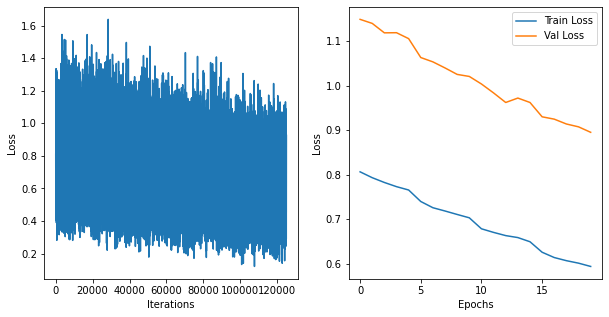

In [30]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

ax1.plot(iteration_losses)
ax1.set_xlabel("Iterations")
ax1.set_ylabel("Loss")

ax2.plot(epoch_losses, label="Train Loss")
ax2.plot(epoch_losses_val, label="Val Loss")
ax2.set_xlabel("Epochs")
ax2.set_ylabel("Loss")

plt.legend()
plt.show()

# 7. Make predictions

In [31]:
#trainset = IndianSceneTextDataset(train_dir) 
#valset = IndianSceneTextDataset(val_dir)
testset = IndianSceneTextDataset(test_dir) 

#train_loader = DataLoader(trainset, batch_size=batch_size, num_workers=8, shuffle=False)
#val_loader = DataLoader(valset, batch_size=batch_size, num_workers=8, shuffle=False)
test_loader = DataLoader(testset, batch_size=batch_size, num_workers=8, shuffle=False)

In [32]:
model_path = f'Models/{language}-Unicode.pth'

crnn = CRNN(len(char2idx), rnn_hidden_size=rnn_hidden_size)
crnn.load_state_dict(torch.load(model_path))
crnn = crnn.to(device)

In [33]:
def decode_predictions(text_batch_logits):

    text_batch_tokens = F.softmax(text_batch_logits, 2).argmax(2) # [T, batch_size]
    text_batch_tokens = text_batch_tokens.numpy().T # [batch_size, T]

    text_batch_tokens_new = []
    for text_tokens in text_batch_tokens:
        text = [idx2char[idx] for idx in text_tokens]
        text = "".join(text)
        text_batch_tokens_new.append(text)

    return text_batch_tokens_new

In [34]:
def make_predictions(data_loader):
    result = pd.DataFrame(columns=['image_fn', 'actual', 'prediction'])
    with torch.no_grad():
        for image_batch, text_batch, image_fn_batch in tqdm(data_loader, leave=False):
            text_batch_logits = crnn(image_batch.to(device)) # [T, batch_size, num_classes==num_features]
            text_batch_pred = decode_predictions(text_batch_logits.cpu())
            #print(text_batch, text_batch_pred)
            df = pd.DataFrame(columns=['actual', 'prediction'])
            df['image_fn'] = image_fn_batch
            df['actual'] = text_batch
            df['prediction'] = text_batch_pred
            result = pd.concat([result, df])
    result = result.reset_index(drop=True)
    return result

In [35]:
train_result = make_predictions(train_loader)
val_result = make_predictions(val_loader)
test_result = make_predictions(test_loader)

In [36]:
print(train_result.shape)
print(val_result.shape)
print(test_result.shape)
train_result.head()

(399989, 3)
(5000, 3)
(5000, 3)


,image_fn,actual,prediction
0,ਨਟ_15_2370_1.jpg,ਨਟ,ਨ----------ਟ-
1,ਮਹਲਾ_22_2076_0.jpg,ਮਹਲਾ,ਮ-----ਹ----ਲਾ
2,ਰੜਾ_20_3276_0.jpg,ਰੜਾ,ਰ----------ੜਾ
3,ਹਲਕਾ_13_717_1.jpg,ਹਲਕਾ,ਹ------ਰ---ਮ-
4,ਇਹ_13_879_7.jpg,ਇਹ,ਇ----------ਹ-


In [37]:
def remove_duplicates(text):
    if len(text) > 1:
        letters = [text[0]] + [letter for idx, letter in enumerate(text[1:], start=1) if text[idx] != text[idx-1]]
    elif len(text) == 1:
        letters = [text[0]]
    else:
        return ""
    return "".join(letters)

def correct_prediction(word):
    parts = word.split("-")
    parts = [remove_duplicates(part) for part in parts]
    corrected_word = "".join(parts)
    return corrected_word

In [38]:
train_result['prediction_corrected'] = train_result['prediction'].apply(correct_prediction)
val_result['prediction_corrected'] = val_result['prediction'].apply(correct_prediction)
test_result['prediction_corrected'] = test_result['prediction'].apply(correct_prediction)

In [39]:
train_result['actual_length'] = train_result['actual'].apply(len)
val_result['actual_length'] = val_result['actual'].apply(len)
test_result['actual_length'] = test_result['actual'].apply(len)

train_result['prediction_length'] = train_result['prediction_corrected'].apply(len)
val_result['prediction_length'] = val_result['prediction_corrected'].apply(len)
test_result['prediction_length'] = test_result['prediction_corrected'].apply(len)

In [40]:
def levenshteinDistance(row):
    
    s1 = row['actual']
    s2 = row['prediction_corrected']
    if len(s1) > len(s2):
        s1, s2 = s2, s1

    distances = range(len(s1) + 1)
    for i2, c2 in enumerate(s2):
        distances_ = [i2+1]
        for i1, c1 in enumerate(s1):
            if c1 == c2:
                distances_.append(distances[i1])
            else:
                distances_.append(1 + min((distances[i1], distances[i1 + 1], distances_[-1])))
        distances = distances_
    return distances[-1]

In [41]:
train_result['edit_distance'] = train_result.progress_apply(levenshteinDistance, axis=1)
val_result['edit_distance'] = val_result.apply(levenshteinDistance, axis=1)
test_result['edit_distance'] = test_result.apply(levenshteinDistance, axis=1)

# 8. Evaluate the model

In [42]:
train_accuracy = accuracy_score(train_result['actual'], train_result['prediction_corrected'])
val_accuracy = accuracy_score(val_result['actual'], val_result['prediction_corrected'])
test_accuracy = accuracy_score(test_result['actual'], test_result['prediction_corrected'])
print(train_accuracy, val_accuracy, test_accuracy)

0.7584708579485936 0.633 0.7188


In [43]:
for max_edit_distance in range(3+1):
    print("Max Edit Distance", max_edit_distance)
    train_accuracy = (train_result['edit_distance'] <= max_edit_distance).sum() / len(train_result)
    val_accuracy = (val_result['edit_distance'] <= max_edit_distance).sum() / len(val_result)
    test_accuracy = (test_result['edit_distance'] <= max_edit_distance).sum() / len(test_result)
    print(train_accuracy, val_accuracy, test_accuracy)
    print("*"*50)

Max Edit Distance 0
0.7584708579485936 0.633 0.7188
**************************************************
Max Edit Distance 1
0.8500058751615669 0.7424 0.8146
**************************************************
Max Edit Distance 2
0.9051423914157639 0.8256 0.882
**************************************************
Max Edit Distance 3
0.9527712012080333 0.908 0.9394
**************************************************


In [44]:
def visualize_misclassifications(split='Train', num_samples=20, max_edit_distance=2):
    
    if split == 'Train':
        result = train_result
    elif split == 'Val':
        result = val_result
    elif split == 'Test':
        result = test_result
        
    mask = result['edit_distance'] >= max_edit_distance
    result = result[mask].sample(n = num_samples)
    for row_id, row in result.iterrows():
        info = 'Actual:', row['actual'], 'Prediction:', row['prediction'], \
              'Prediction Corrected:', row['prediction_corrected']
        print(info)
        
        image_fp = f'Data/{language}/{split}/{row["image_fn"]}'
        plt.imshow(Image.open(image_fp))
        plt.axis(False)
        plt.show()
    

('Actual:', 'ਜਾਪ', 'Prediction:', 'ਸ----------ਨ-', 'Prediction Corrected:', 'ਸਨ')


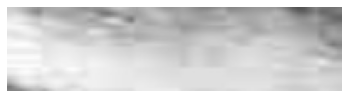

('Actual:', 'ਰਹੀ', 'Prediction:', 'ਕ----------ਨ-', 'Prediction Corrected:', 'ਕਨ')


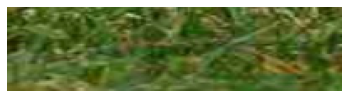

('Actual:', 'ਚੈਚਨੀਆ', 'Prediction:', 'ਕ------ਰ---ਨ-', 'Prediction Corrected:', 'ਕਰਨ')


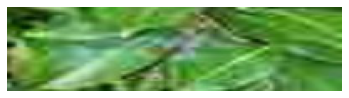

('Actual:', 'ਅਸਾਮ', 'Prediction:', 'ਅ-------ਪਾ-ਰ-', 'Prediction Corrected:', 'ਅਪਾਰ')


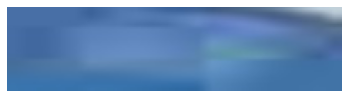

('Actual:', 'ਰਸਕਿਨ', 'Prediction:', 'ਰ---ਾਮ--ਕਿ-ਨ-', 'Prediction Corrected:', 'ਰਾਮਕਿਨ')


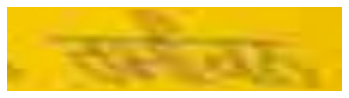

('Actual:', 'ਹੈਕਟੇਅਰ', 'Prediction:', 'ਵ--ੋ---ਟ---ਆ-', 'Prediction Corrected:', 'ਵੋਟਆ')


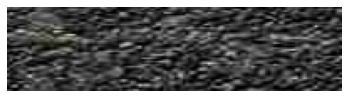

('Actual:', 'ਸਰਦਾਰ', 'Prediction:', 'ਸ----ਰਾਦ---ਰਾ', 'Prediction Corrected:', 'ਸਰਾਦਰਾ')


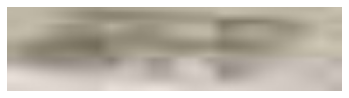

('Actual:', 'ਵਰਨਰ', 'Prediction:', 'ਕ----------ਰ-', 'Prediction Corrected:', 'ਕਰ')


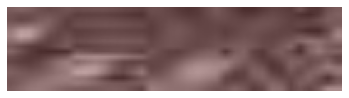

('Actual:', 'ਕਲੰਦਰ', 'Prediction:', 'ਲ-------ਕ--ਰ-', 'Prediction Corrected:', 'ਲਕਰ')


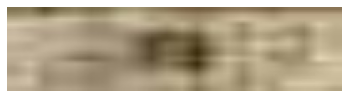

('Actual:', 'ਪਾਈ', 'Prediction:', 'ਹ------ਾ---ਇ-', 'Prediction Corrected:', 'ਹਾਇ')


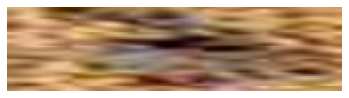

('Actual:', 'ਤਈਜ਼', 'Prediction:', 'ਦ----------ਕ-', 'Prediction Corrected:', 'ਦਕ')


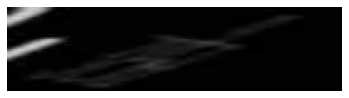

('Actual:', 'ਕਥ', 'Prediction:', 'ਹ----------ਰ-', 'Prediction Corrected:', 'ਹਰ')


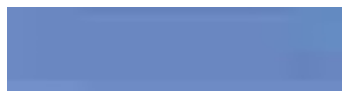

('Actual:', 'ਸਾਲ', 'Prediction:', 'ਸ----------ਭ-', 'Prediction Corrected:', 'ਸਭ')


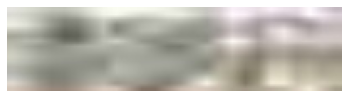

('Actual:', 'ਅਰੇਨਾ', 'Prediction:', 'ਅ----------ਲ-', 'Prediction Corrected:', 'ਅਲ')


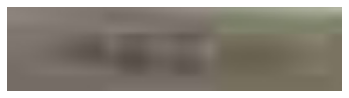

('Actual:', 'ਆਰਮਾਨੀ', 'Prediction:', 'ਜ----ਰ-ਪ---ਰੀ', 'Prediction Corrected:', 'ਜਰਪਰੀ')


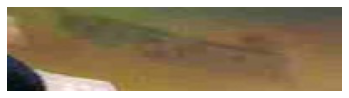

('Actual:', 'ਅੰਧ', 'Prediction:', 'ਪ----------ਪ-', 'Prediction Corrected:', 'ਪਪ')


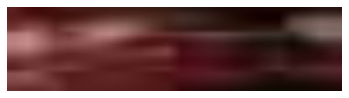

('Actual:', 'ਪੂਰਨ', 'Prediction:', 'ਸ----------ਰ-', 'Prediction Corrected:', 'ਸਰ')


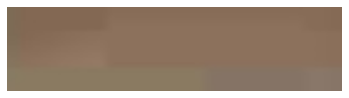

('Actual:', 'ਅਸਤਿਤ੍ਵਵਾਦ', 'Prediction:', 'ਅ--ਸ-ਤਿਤਵਵਵਾਣ', 'Prediction Corrected:', 'ਅਸਤਿਤਵਾਣ')


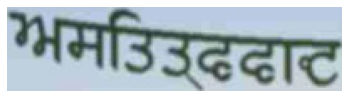

('Actual:', 'ਬੇਲਰ', 'Prediction:', 'ਲ----ੈ-ਲ---ਲ-', 'Prediction Corrected:', 'ਲੈਲਲ')


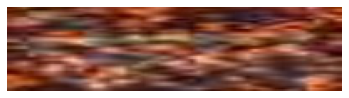

('Actual:', 'ਆਟਾ', 'Prediction:', 'ਅ---------ਰ--', 'Prediction Corrected:', 'ਅਰ')


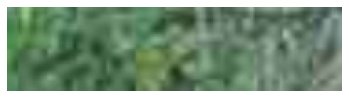

In [45]:
visualize_misclassifications('Train')

('Actual:', 'ਰਹਾਉ', 'Prediction:', 'ਕ----------ਰ-', 'Prediction Corrected:', 'ਕਰ')


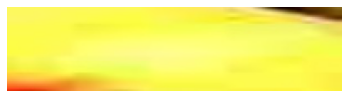

('Actual:', 'ਕਲ', 'Prediction:', 'ਪ----------ਰ-', 'Prediction Corrected:', 'ਪਰ')


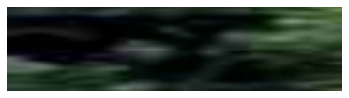

('Actual:', 'ਘਮੀਰਪੁਰ', 'Prediction:', 'ਕ----------ਲ-', 'Prediction Corrected:', 'ਕਲ')


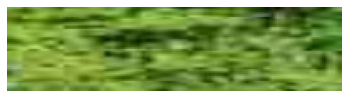

('Actual:', 'ਫਕਰ', 'Prediction:', 'ਕ------ਰ---ਰ-', 'Prediction Corrected:', 'ਕਰਰ')


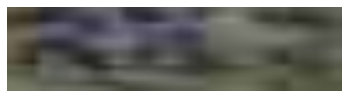

('Actual:', 'ਗੁਰ', 'Prediction:', 'ਕ----------ਰ-', 'Prediction Corrected:', 'ਕਰ')


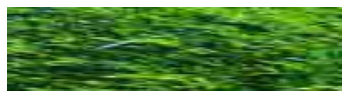

('Actual:', 'ਇਰਾਨ', 'Prediction:', 'ਸ-----ਰ----ਸ-', 'Prediction Corrected:', 'ਸਰਸ')


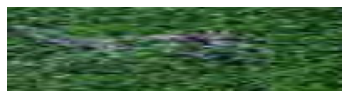

('Actual:', 'ਮਾਰਚ', 'Prediction:', 'ਸ-----ਾ-ਰ--ਬ-', 'Prediction Corrected:', 'ਸਾਰਬ')


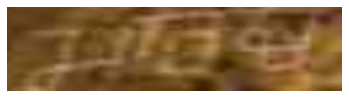

('Actual:', 'ਪਰਤ', 'Prediction:', 'ਖ------ਰ---ਣ-', 'Prediction Corrected:', 'ਖਰਣ')


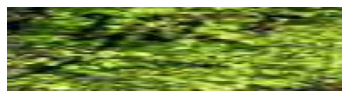

('Actual:', 'ਪਿਆਰ', 'Prediction:', 'ਪ----------ਰ-', 'Prediction Corrected:', 'ਪਰ')


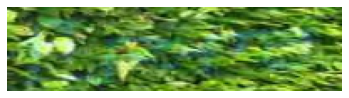

('Actual:', 'ਜਨਿ', 'Prediction:', 'ਹ----------ਹਿ', 'Prediction Corrected:', 'ਹਹਿ')


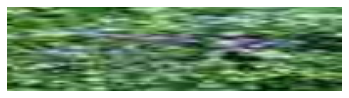

('Actual:', 'ਦੀਆ', 'Prediction:', 'ਵ-----ਰੀ---ਆ-', 'Prediction Corrected:', 'ਵਰੀਆ')


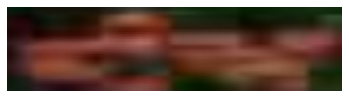

('Actual:', 'ਬਾਲਡਵਿਨ', 'Prediction:', 'ਸ----------ਭ-', 'Prediction Corrected:', 'ਸਭ')


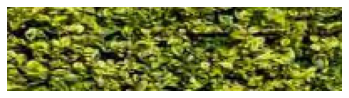

('Actual:', 'ਕਰਨਲ', 'Prediction:', 'ਕ----------ਰ-', 'Prediction Corrected:', 'ਕਰ')


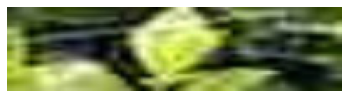

('Actual:', 'ਚਰਮਣਹ', 'Prediction:', 'ਚ---ਰ--ਮ-ਣ-ਪੁ', 'Prediction Corrected:', 'ਚਰਮਣਪੁ')


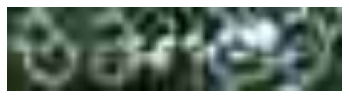

('Actual:', 'ਰਹੇ', 'Prediction:', 'ਉ----------ਹ-', 'Prediction Corrected:', 'ਉਹ')


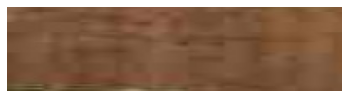

('Actual:', 'ਅਫ਼ਗਾਨ', 'Prediction:', 'ਮ-----ਸ----ਰ-', 'Prediction Corrected:', 'ਮਸਰ')


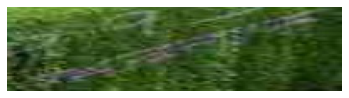

('Actual:', 'ਦੇਣ', 'Prediction:', 'ਚ-----ੋ----ਣ-', 'Prediction Corrected:', 'ਚੋਣ')


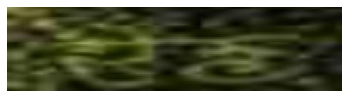

('Actual:', 'ਪੱਛਮ', 'Prediction:', 'ਸ----------ਲ-', 'Prediction Corrected:', 'ਸਲ')


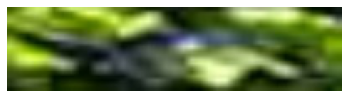

('Actual:', 'ਕੰਕਰ', 'Prediction:', 'ਕ----ੇ-----ਰ-', 'Prediction Corrected:', 'ਕੇਰ')


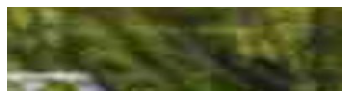

('Actual:', 'ਬੱਲ', 'Prediction:', 'ਸ----------ਰ-', 'Prediction Corrected:', 'ਸਰ')


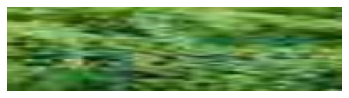

In [46]:
visualize_misclassifications('Val')

('Actual:', 'ਸਭ', 'Prediction:', 'ਜ----------ਬ-', 'Prediction Corrected:', 'ਜਬ')


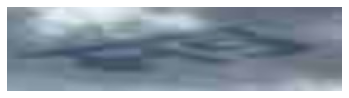

('Actual:', 'ਅੰਕ', 'Prediction:', 'ਮ------ੰ---ਤ-', 'Prediction Corrected:', 'ਮੰਤ')


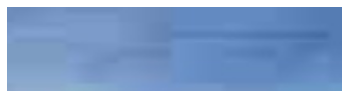

('Actual:', 'ਏਏਏ', 'Prediction:', 'ਪ-----ਰ----ਏ-', 'Prediction Corrected:', 'ਪਰਏ')


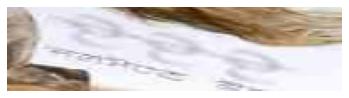

('Actual:', 'ਸੁਆਦ', 'Prediction:', 'ਸ---ੂ--ਅ---ਬ-', 'Prediction Corrected:', 'ਸੂਅਬ')


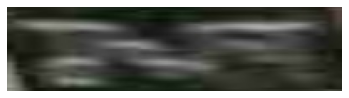

('Actual:', 'ਰਜਿਸਟਰਡ', 'Prediction:', 'ਹ----------ਰ-', 'Prediction Corrected:', 'ਹਰ')


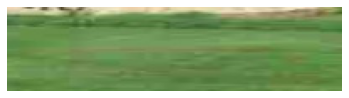

('Actual:', 'ਮਹਲਾ', 'Prediction:', 'ਸ----------ਜ-', 'Prediction Corrected:', 'ਸਜ')


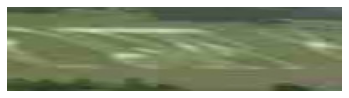

('Actual:', 'ਅਕਬਰਵਾਲਾ', 'Prediction:', 'ਅ--ਕ-ਸ-ਰਰਡਾਲ-', 'Prediction Corrected:', 'ਅਕਸਰਡਾਲ')


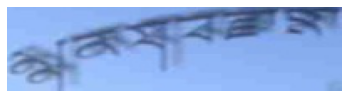

('Actual:', 'ਰਹਾਉ', 'Prediction:', 'ਮ------ਾ---ਈ-', 'Prediction Corrected:', 'ਮਾਈ')


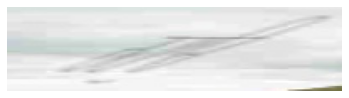

('Actual:', 'ਗੁਰੂ', 'Prediction:', 'ਗ-----ੁੂ---ਰ-', 'Prediction Corrected:', 'ਗੁੂਰ')


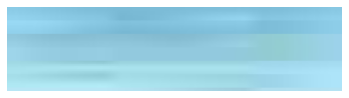

('Actual:', 'ਕਮਲ', 'Prediction:', 'ਗ----------ਆ-', 'Prediction Corrected:', 'ਗਆ')


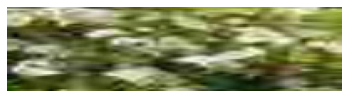

('Actual:', 'ਹਨ', 'Prediction:', 'ਵ----------ਡ-', 'Prediction Corrected:', 'ਵਡ')


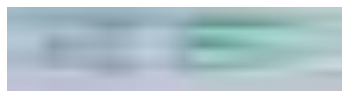

('Actual:', 'ਰੱਖ', 'Prediction:', 'ਹ----ੋ-----ਣ-', 'Prediction Corrected:', 'ਹੋਣ')


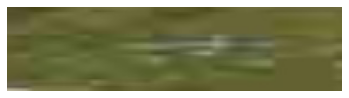

('Actual:', 'ਲੋੜ', 'Prediction:', 'ਪ----------ਰ-', 'Prediction Corrected:', 'ਪਰ')


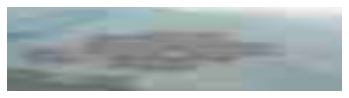

('Actual:', 'ਡਾਲਰ', 'Prediction:', 'ਫ--ਾ-ਸ-ਟ-ਕ-ਰ-', 'Prediction Corrected:', 'ਫਾਸਟਕਰ')


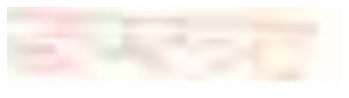

('Actual:', 'ਸਮਾਜਵਾਦ', 'Prediction:', 'ਸ------ਜ---ਬ-', 'Prediction Corrected:', 'ਸਜਬ')


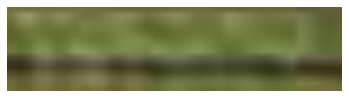

('Actual:', 'ਬਿਕਰਾਲ', 'Prediction:', 'ਬ---ਿਸਆਰਾ--ਲ-', 'Prediction Corrected:', 'ਬਿਸਆਰਾਲ')


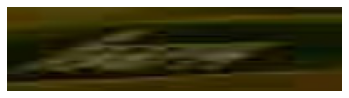

('Actual:', 'ਪਸੰਦ', 'Prediction:', 'ਸ------ਮ---ਦ-', 'Prediction Corrected:', 'ਸਮਦ')


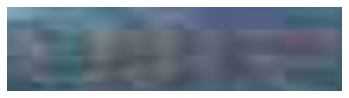

('Actual:', 'ਕਰਾਫਟਵਰਕ', 'Prediction:', 'ਕ---ਰਾਾਰਣ--ਕਕ', 'Prediction Corrected:', 'ਕਰਾਰਣਕ')


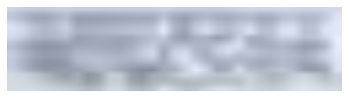

('Actual:', 'ਇਕ', 'Prediction:', 'ਦ----ੰ-----ਰ-', 'Prediction Corrected:', 'ਦੰਰ')


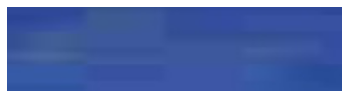

('Actual:', 'ਰਹਾਉ', 'Prediction:', 'ਸ------ਾ---ਤੇ', 'Prediction Corrected:', 'ਸਾਤੇ')


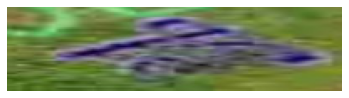

In [47]:
visualize_misclassifications('Test')

### References:
[1] https://github.com/carnotaur/crnn-tutorial/

Loss cannot be reduced beyond 0.54 in val set (after 20 epochs)